In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="InvertedFiles", version="0.4"),
    PackageSpec(name="TextSearch", version="0.13"),
    PackageSpec(name="Clustering", version="0.14"),
    PackageSpec(name="HypertextLiteral", version="0.9"),
    PackageSpec(name="DataFrames"),
    PackageSpec(name="Plots", version="1"),
    PackageSpec(name="JSON", version="0.21"),
    PackageSpec(name="CSV", version="0.10"),
    PackageSpec(name="CategoricalArrays", version="0.10")
])

using SimilaritySearch, InvertedFiles, TextSearch, SimSearchManifoldLearning, Clustering, DataFrames, Statistics, StatsBase, Plots, CSV, JSON, HypertextLiteral, CategoricalArrays, Dates
using Plots.PlotMeasures

  Activating project at `~/Research/CorpusVisualizationNotebooks`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/CorpusVisualizationNotebooks/Project.toml`
  No Changes to `~/Research/CorpusVisualizationNotebooks/Manifest.toml`


In [2]:
Pkg.status()

Status `~/Research/CorpusVisualizationNotebooks/Project.toml`
  [336ed68f] CSV v0.10.4
  [324d7699] CategoricalArrays v0.10.7
  [aaaa29a8] Clustering v0.14.3
  [a93c6f00] DataFrames v1.4.1
  [ac1192a8] HypertextLiteral v0.9.4
  [b20bd276] InvertedFiles v0.4.3
  [682c06a0] JSON v0.21.3
  [91a5bcdd] Plots v1.35.3
  [ca7ab67e] SimSearchManifoldLearning v0.2.5
  [053f045d] SimilaritySearch v0.9.7
  [7f6f6c8a] TextSearch v0.13.1


In [3]:
inputfile = "../datasets/datasets/delitos_ingeotec_Es_train.json"
outfile = replace(basename(inputfile), r".json" => "") * ".csv"
model_mindocs = 3
model_maxdocs = 100
use_labels = true

textconfig = TextConfig(
                group_usr=true,
                group_url=true,
                del_diac=true,
                lc=true,
                group_num=true,
                nlist=[1,2],
                qlist=[4]
)

TextConfig(true, false, false, true, true, true, false, true, Int8[4], Int8[1, 2], Skipgram[], IdentityTokenTransformation())

In [4]:
function parse_corpus(datafile)
        D = DataFrame(objID=Int[], id=Int64[], klass=Int[], text=String[])
        for (i, line) in enumerate(eachline(datafile))
                t = JSON.parse(line)
                push!(D, (i, t["id"], t["klass"], t["text"]))
        end

        D
end

function text_model(corpus; labels, mindocs, maxdocs)
    model = if isnothing(labels)
        model = VectorModel(IdfWeighting(), TfWeighting(), textconfig, corpus)
        filter_tokens(model) do t
                mindocs <= t.occs <= maxdocs
        end
    else
        V = filter_tokens(Vocabulary(textconfig, corpus)) do t
            mindocs <= t.occs <= maxdocs
        end
        C = vectorize_corpus(V, textconfig, corpus)
        VectorModel(EntropyWeighting(), TfWeighting(), V, C, categorical(labels); mindocs, smooth=1.0)
    end

    vectors = vectorize_corpus(model, textconfig, corpus)

    (; textconfig, model, vectors)
end

function create_dataset(corpusfile; labels=nothing, mindocs=3, maxdocs=700)
    corpus = parse_corpus(corpusfile)
    labels = isnothing(labels) ? nothing : corpus.klass
    D = text_model(corpus.text; labels, mindocs, maxdocs)
    # D = text_model(corpus.text, corpus.klass)
    (; corpus, D...)
end

function create_index(model, db)
    #=db = VectorDatabase(db)
    dist = NormalizedCosineDistance()
    G = SearchGraph(; db, dist, verbose=false)
    index!(G; parallel_block=256)
    optimize!(G, MinRecall(0.9))
    G=#

    WeightedInvertedFile(vocsize(model), VectorDatabase(db)) |> index!
end

create_index (generic function with 1 method)

In [5]:
D = create_dataset(inputfile;
            labels=use_labels,
            mindocs=model_mindocs,
            maxdocs=model_maxdocs
    )
#SimilaritySearch.database(invfile::WeightedInvertedFile) = D.vectors
#SimilaritySearch.database(invfile::WeightedInvertedFile, i) = D.vectors[i]

names(D.corpus), size(D.corpus), keys(D)

(["objID", "id", "klass", "text"], (1440, 4), (:corpus, :textconfig, :model, :vectors))

┌ Info: klass dist: Dict(0 => 1067, 1 => 373)
└ @ Main In[6]:2


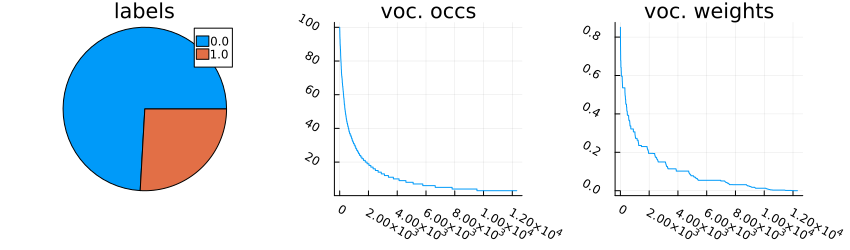

In [6]:
m = countmap(D.corpus.klass)
@info "klass dist: $m"
p1 = pie(m, size=(300, 100), title="labels")
p2 = plot(sort(D.model.voc.occs, rev=true), title="voc. occs", label="", rot=-30)
p3 = plot(sort(D.model.weight, rev=true), title="voc. weights", label="", rot=-30)
plot(p1, p2, p3, size=(850, 250), right_margin=10mm, bottom_margin=7mm, layout=@layout [a b c])

In [7]:
function show_results(res, R)
    colors_ = ["rgb(200, 100, 100)", "rgb(100, 100, 200)"]

    L = []
    for (i, (objID, d)) in enumerate(res)
            d = round(d,  digits=3)
            push!(L, @htl """<tr style="color: $(colors_[i % 2 + 1]);">
            <td>$i</td> <td>$d</td>
            <td>$(R.klass[i])</td>
            <td>$(R.text[i])</td>
            </tr>""")
    end

    @htl """
            <table><tbody>
                    $L
            </tbody></table>
    """

end

show_results (generic function with 1 method)

In [8]:
S = create_index(D.model, VectorDatabase(D.vectors));

In [9]:
function search_text(D, qtext; k=7)
    C = D.corpus
    res = KnnResult(k)
    search(S, vectorize(D.model, D.textconfig, qtext), res)
    R = D.corpus[idview(res), :]

    @htl """

    <div style="margin: 2pt;">
    <span style="left-margin: 2pt;">$(show_results(res, R))</span>
    </div>
     """
end

search_text (generic function with 1 method)

In [19]:
search_text(D, "violencia y asesinatos")

1,0.533,0,@ARENAfraccion @ravelpak Exceso de asesinatos por parte de @ARENAOFICIAL https://t.co/rInj8o64wS
2,0.615,0,Comienzan en Entre Ríos los alegatos del juicio al represor Carlos Carvallo https://t.co/sSlOGJPJQq vía @Noticiasde_
3,0.649,0,"Alguien más siente el “4G” de kolbi como GPRS? (No, no he gastado todos mis datos)"
4,0.669,0,#GritoporNicaragua Que las madres de los asesinados tengan justicia para sus hijos. Que no hayan mas asesinatos por fuerzas para policiales y policiales en Nicaragua.#SOSNicaragua
5,0.711,0,Un rojo detenido en Zaragoza y dos catalanes investigados por alegrarse en Twitter de los asesinatos de dos guardias civiles – Alerta Digital https://t.co/6yGiO5UQHg
6,0.719,0,"Ayuda a @PETA_Latino a proteger a los monos, perros, gatos y otros animales de ser atormentados y asesinados en horribles experimentos:https://t.co/LWVtw2RCEc. ¡Por favor, RT!"
7,0.731,0,"Viena, frente a la Embajada de #Colombia. Hoy #26J en el plantón internacional contra la violencia y asesinatos de activistas colombianas. ¡Basta! Alto al exterminio sistemático de lideres/as colombianas.¡Estado responsable! https://t.co/gDfePotAAO"


In [11]:
function load_or_create_umap_embeddings(index;
        k=50,
        n_epochs=100,
        neg_sample_rate=3,
        tol=1e-3,
        layout=RandomLayout()
    )
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-dat
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

plot_kwargs = (ma=0.3, a=0.3, ms=2, msw=0) # yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)

function plot_umap(e2, e3, labels)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]


    P1 = scatter(X, Y; c=C, fmt=:png, size=(400, 400), label="", plot_kwargs...)
    plot!(title="colors are related to spatial proximity in the 3d projection")
    P2 = scatter(X, Y; c=labels, palette = :Set1_3, fmt=:png, size=(400, 400), label="", plot_kwargs...)
    plot(P1, P2, title=["colors ~ 3d projection" "colors ~ labels"], size=(800, 400))
end


plot_umap (generic function with 1 method)

In [12]:
UMAP_K = 10
e2, e3 = load_or_create_umap_embeddings(S; layout=SpectralLayout(), k=UMAP_K, tol=1e-4)

  0.177907 seconds (205 allocations: 900.750 KiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  3.291417 seconds (4.55 M allocations: 524.130 MiB, 6.68% gc time, 88.87% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.100567214
- embedding init: 2.327725505
- embedding opt: 0.103032849



  0.109604 seconds (130 allocations: 54.844 KiB, 6.72% compilation time)


(e2 = Float32[-1.7682358 0.62101144 … 3.414749 -1.7085487; 2.860106 -1.0814304 … 4.8407645 2.8769553], e3 = Float32[-1.796462 0.71391284 … 3.2706742 -1.7903537; 1.5759183 0.86599946 … 4.992979 1.6278111; -4.2960415 0.91018575 … -0.3089254 -4.3247523])

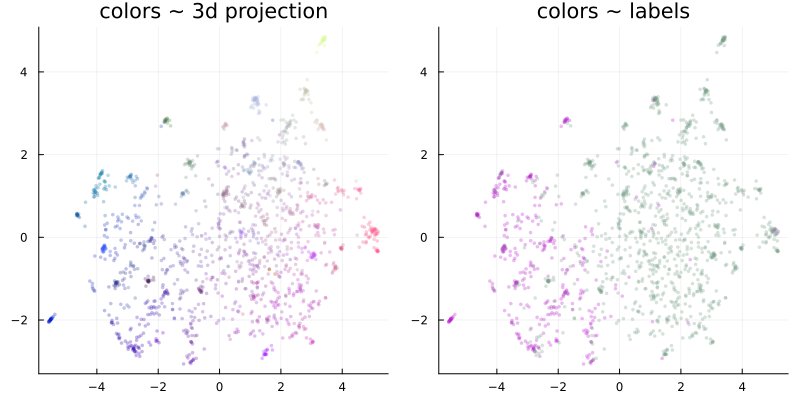

In [13]:
plot_umap(e2, e3, D.corpus.klass)

In [14]:
begin
    min_cluster_size = 10
    eps_ = 0.1
    vclusters = dbscan(e2, eps_; min_cluster_size)

    @htl """
    <div style="display: inline-block; vertical-align: top; margin: 1em;">
            <div>number of clusters: $(length(vclusters))</div>
            <div>eps: $eps_</div>
            <div>min size: $min_cluster_size</div>
    </div><div style="display: inline-block;">
    $(histogram([c.size for c in vclusters], bins=10, size=(300, 300))) </div>
    """
end

<div style="display: inline-block; vertical-align: top; margin: 1em;">
        <div>number of clusters: 33</div>
        <div>eps: 0.1</div>
        <div>min size: 10</div>
</div><div style="display: inline-block;">
<?xml version="1.0" encoding="utf-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="300" height="300" viewBox="0 0 1200 1200">
<defs>
  <clipPath id="clip020">
    <rect x="0" y="0" width="1200" height="1200"/>
  </clipPath>
</defs>
<path clip-path="url(#clip020)" d="
M0 1200 L1200 1200 L1200 0 L0 0  Z
  " fill="#ffffff" fill-rule="evenodd" fill-opacity="1"/>
<defs>
  <clipPath id="clip021">
    <rect x="240" y="120" width="841" height="841"/>
  </clipPath>
</defs>
<path clip-path="url(#clip020)" d="
M100.177 1073.17 L1152.76 1073.17 L1152.76 47.2441 L100.177 47.2441  Z
  " fill="#ffffff" fill-rule="evenodd" fill-opacity="1"/>
<defs>
  <clipPath id="clip022">
    <rect x="100" y="47" width="1054" height="1027"/>
  </clipPath>
</defs>
<polyline clip-path="url(#clip022)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:2; stroke-opacity:0.1; fill:none" points="
  158.071,1073.17 158.071,47.2441 
  "/>
<polyline clip-path="url(#clip022)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:2; stroke-opacity:0.1; fill:none" points="
  370.978,1073.17 370.978,47.2441 
  "/>
<polyline clip-path="url(#clip022)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:2; stroke-opacity:0.1; fill:none" points="
  583.885,1073.17 583.885,47.2441 
  "/>
<polyline clip-path="url(#clip022)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:2; stroke-opacity:0.1; fill:none" points="
  796.792,1073.17 796.792,47.2441 
  "/>
<polyline clip-path="url(#clip022)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:2; stroke-opacity:0.1; fill:none" points="
  1009.7,1073.17 1009.7,47.2441 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  100.177,1073.17 1152.76,1073.17 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  158.071,1073.17 158.071,1054.27 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  370.978,1073.17 370.978,1054.27 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  583.885,1073.17 583.885,1054.27 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  796.792,1073.17 796.792,1054.27 
  "/>
<polyline clip-path="url(#clip020)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="
  1009.7,1073.17 1009.7,1054.27 
  "/>
<path clip-path="url(#clip020)" d="M132.759 1122.03 L140.397 1122.03 L140.397 1095.67 L132.087 1097.33 L132.087 1093.07 L140.351 1091.41 L145.027 1091.41 L145.027 1122.03 L152.666 1122.03 L152.666 1125.97 L132.759 1125.97 L132.759 1122.03 Z" fill="#000000" fill-rule="evenodd" fill-opacity="1" /><path clip-path="url(#clip020)" d="M172.11 1094.49 Q168.499 1094.49 166.67 1098.05 Q164.865 1101.59 164.865 1108.72 Q164.865 1115.83 166.67 1119.39 Q168.499 1122.94 172.11 1122.94 Q175.744 1122.94 177.55 1119.39 Q179.379 1115.83 179.379 1108.72 Q179.379 1101.59 177.55 1098.05 Q175.744 1094.49 172.11 1094.49 M172.11 1090.78 Q177.92 1090.78 180.976 1095.39 Q184.055 1099.97 184.055 1108.72 Q184.055 1117.45 180.976 1122.06 Q177.92 1126.64 172.11 1126.64 Q166.3 1126.64 163.221 1122.06 Q160.166 1117.45 16

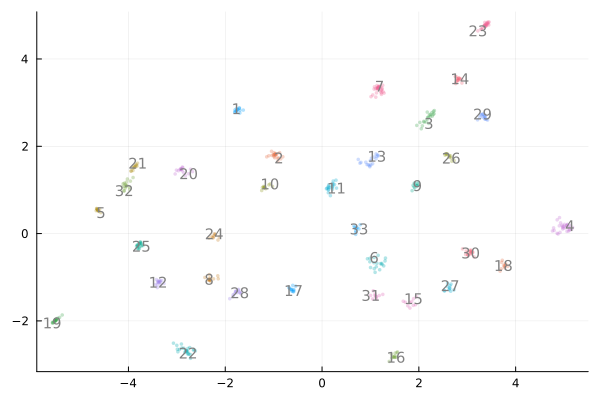

In [15]:
begin
    plot()

    for (i, c) in enumerate(vclusters)
        scatter!(e2[1, c.core_indices], e2[2, c.core_indices]; c=:auto, label="", plot_kwargs...)
        annotate!(e2[1, first(c.core_indices)], e2[2, first(c.core_indices)], text("$i", :gray, 10, 0.3))
    end

    plot!()
end

In [16]:
begin
    clusterID = 11
    show_qgrams = false
    @htl """
    <h2>Inspect cluster</h2>
    <div>cluster: $clusterID</div>
    <div style="display: inline-block; vertical-align: top;">qgrams: $show_qgrams</div>
    """
end

<h2>Inspect cluster</h2>
<div>cluster: 11</div>
<div style="display: inline-block; vertical-align: top;">qgrams: false</div>

In [17]:
begin
        centroid_ = sum(D.vectors[vclusters[clusterID].core_indices])
        centroid__ = Dict{String,Float32}()
        for (i, d) in centroid_
                i == 0 && continue
                w = token(D.model.voc, i)
                t = if first(w) == '\t'
                        #replace(w[3:end], r"\s" => "~")
                        w[2] == 'n' && show_qgrams == "hide" ? replace(w[3:end], r"\s" => "-") : nothing
                else
                        w
                end

                if !isnothing(t)
                        centroid__[t] = d
                end
        end

        #centroid = Dict(fmt(token(D.model.voc, i)) => d for (i, d) in centroid if i > 0)
    L = []
        for (i, (t, w)) in enumerate(sort(collect(centroid__), by=last, rev=true))
                i == 100 && break
                w = round(w, digits=3)
                fs = ceil(Int, (w+1)^1.5+5)
                push!(L, @htl """ <span style="font-size: $(fs)pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
 padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">$t ($w)</span>""")
        end
        @htl """
        <div style="display: inline-block; writing-mode: vertical-lr; text-orientation: mixed;">cluster: $clusterID</div><div style="display: i
nline-block;">$L</div>
        """
        #=

        =#
end

<div style="display: inline-block; writing-mode: vertical-lr; text-orientation: mixed;">cluster: 11</div><div style="display: i
nline-block;"> <span style="font-size: 13pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">aqui (2.988)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">asesinado (0.459)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">!! (0.392)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">todo (0.362)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">! (0.357)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">asesinato (0.325)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">orden (0.306)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">estamos (0.285)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">camioneta (0.279)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">!!! (0.235)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">dia (0.222)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">ley (0.22)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">hermano (0.199)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">ladrones (0.192)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">antes (0.185)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">mejor (0.178)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">prensa (0.177)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">detras (0.17)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">unidad (0.165)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">| (0.156)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">urgente (0.155)</span> <span style="font-size: 7pt; background-color: white; color: black; display: inline-block; margin: 0.3em;
padding: 2pt; border-radius: 3pt 3pt 3pt 3pt;">transito (0.14)</span> <span style="font-size:

In [18]:
begin
        cluster = D.corpus[vclusters[clusterID].core_indices, :]

        @htl """
        <h2>Inspecting cluster $clusterID</h2>
        <div>$cluster</div>
        """
end

Row,objID,id,klass,text
,Int64,Int64,Int64,String
1,40,1331280452120875008,0,@Wini83 @robersantacruz @juanjoph_73 @DCCoruna Aquí lo que valen son los números. Y por números Fernando Vázquez es el mejor entrenador del Depor de los últimos diez años por lo menos.
2,91,1171790379693289472,0,"@mesalvess Ata, ah, tá! Inocente ela"
3,107,1226763418260197376,0,"Nuevo giro en el asesinato de Marta | La pelea de Miguel con su hermano no fue por el impago de un préstamo sino que pretendía encubrir ""una trama de estafas y falsedades para la concesión de hipotecas"". Aquí los detalles. ⬇ https://t.co/S1iywagndr"
4,191,1348453011643920387,0,"#ATMinforma | Se habilita a la circulación vehicular Av. Juan Tanca Marengo y Av. del Santuario, debido a un siniestro de tránsito en el sitio.\n\n¡Trabajamos #PorTuSeguridad vial!"
5,214,951684334964166656,0,¡¡URGENTE!!\nEl directivo Alfaro Moreno ANUNCIA OTRA GRAN SORPRESA para los barcelonistas.\nAQUÍ EL VIDEO ➡ https://t.co/NcqarYA9vr https://t.co/8zu4kXeAxc
6,361,1268247983071641601,0,@theshortk @DiarioLibre Aquí estamos defendiendo la patria.
7,401,1106890364932239361,0,@diegorcaceresok A los corruptos .ladrones . asesinos. le dan prensa.
8,464,1282308211656327171,0,"@gusbermudezok Aquí está Tigrotta cuando todavía estaba en Santa Margherita, detrás de la cocina. Tuve que darle de comer por un lado; de lo contrario, no comió, todos lo llevaron y allí estaba el hermano que desapareció. https://t.co/pBrPWVF49C"
9,710,1106910128425656320,0,"@marubimo @AdaColau Antes de decírselo, ella menciona al alcohol... Todo en orden."
